In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [ ]:
import torch
import torchvision


from config import (
    IMAGE_DIMENSION_CIFAR,
    get_device,
    WEIGHT_DECAY,
    BATCH_SIZE_PRO,
)
from utils import (
    download_cifar100,
    get_data_loaders,
    print_model_summary,
)

print(torch.__version__)
print(torchvision.__version__)


DEVICE: torch.device = get_device()


2.10.0+cu128
0.25.0+cu128
Using DEVICE: cuda


In [3]:
train_dataset, test_dataset = download_cifar100(img_dimensions=IMAGE_DIMENSION_CIFAR)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


CIFAR-100 ready  train=50000  test=10000  channels=3

Dataset Statistics:
Training samples: 50000
Testing samples: 10000
Number of classes: 100
Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',

In [4]:
train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset, train_dataset=train_dataset, batch_size=BATCH_SIZE_PRO
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


DataLoader Information:
Train batches: 782
Test batches: 157


In [5]:
images, labels = next(iter(train_dataloader))
print(f"Images: {images.shape}")
print(f"Labels: {labels.shape}")


Images: torch.Size([64, 3, 32, 32])
Labels: torch.Size([64])


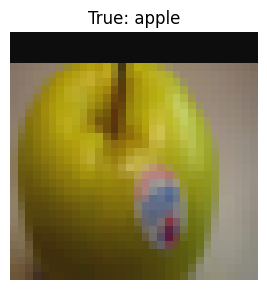

In [6]:
from utils import (
    show_img,
    show_wavelet_subbands,
    show_gabor_responses,
    show_log_responses,
    show_lbp_responses,
    show_dog_responses,
    apply_sobel_for_vis,
    show_img_grayscale,
)

show_img(images[5], labels[5], classes_str=class_names)


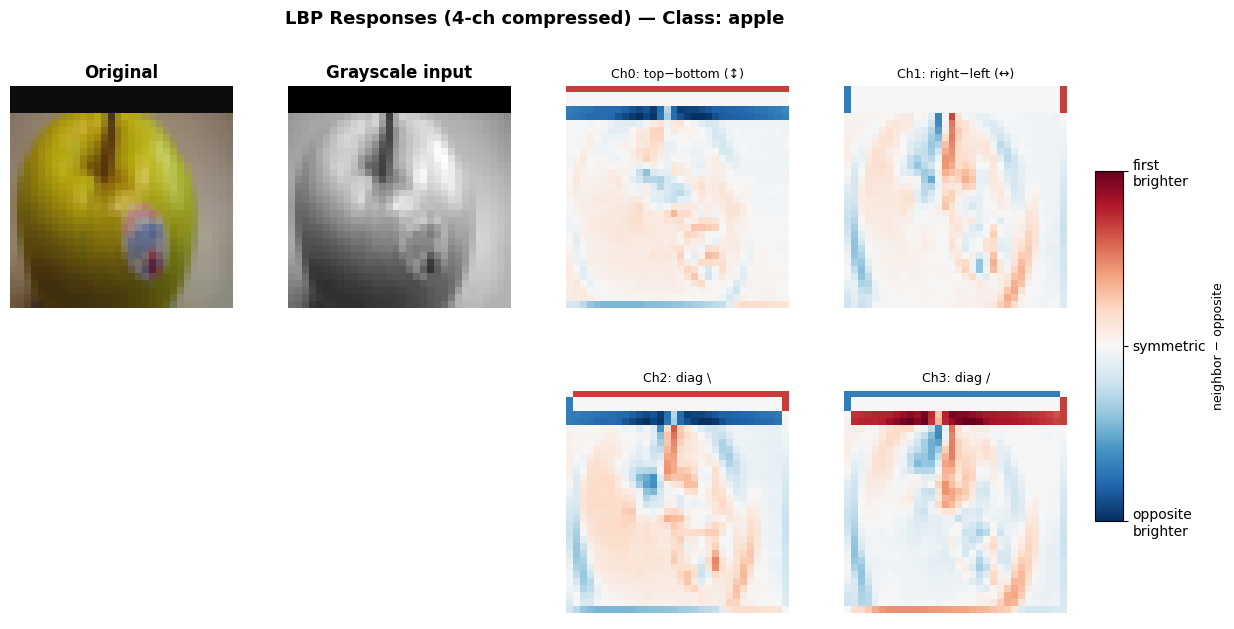

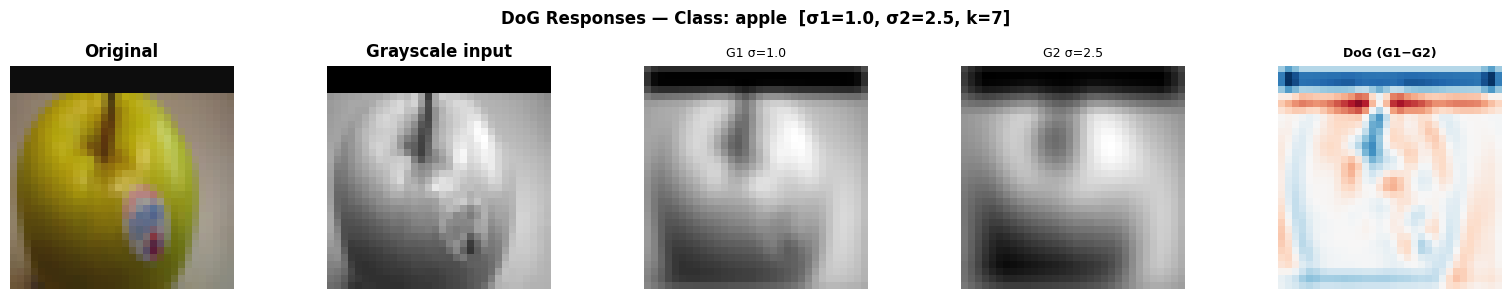

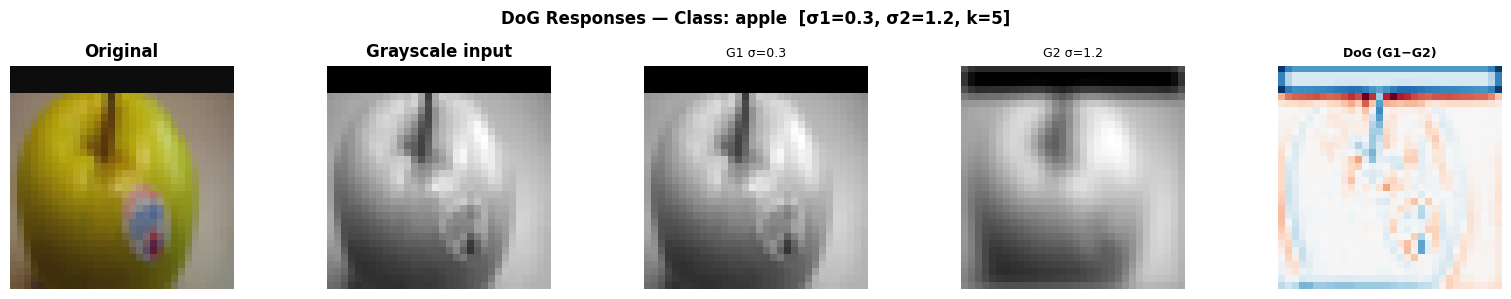

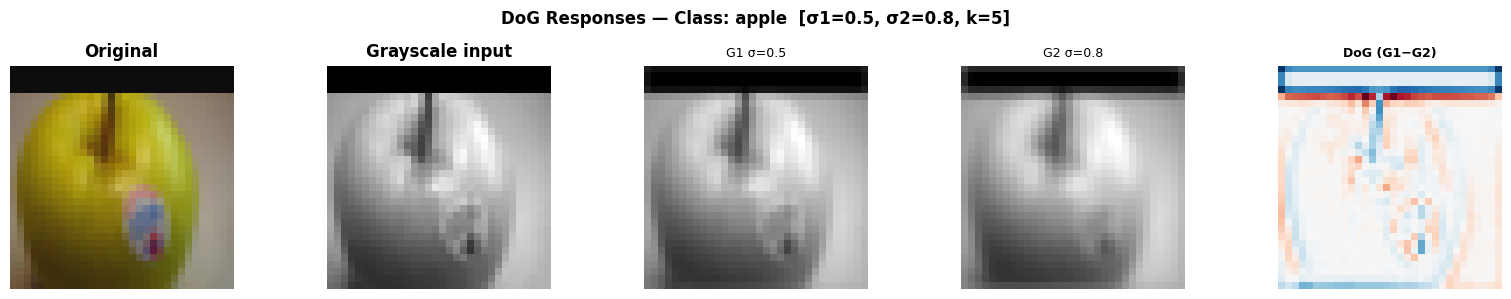

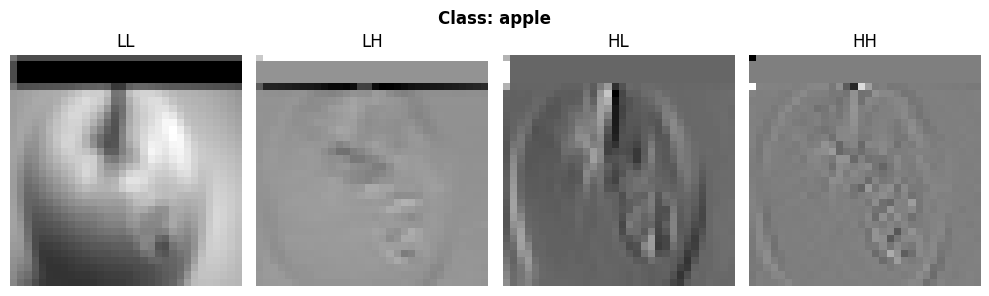

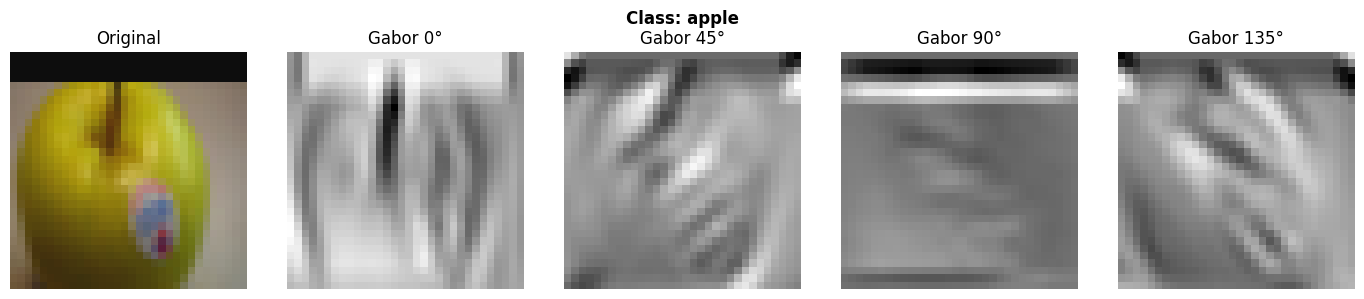

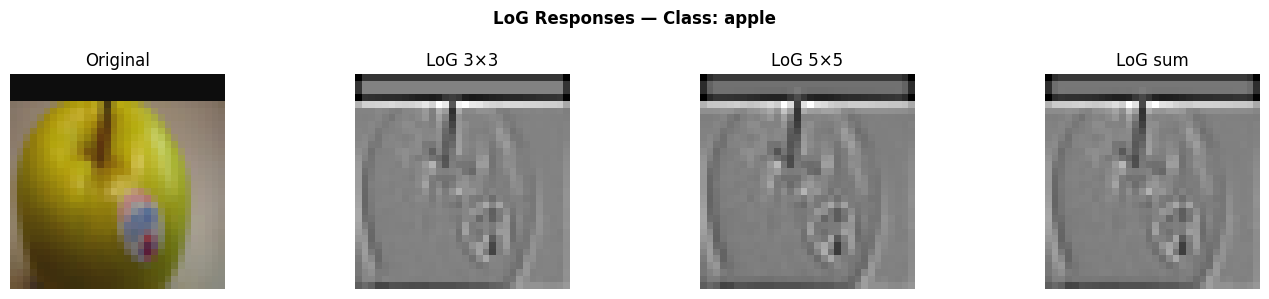

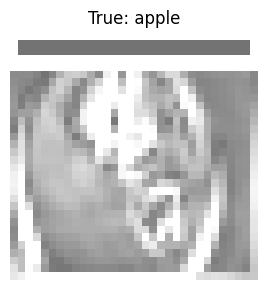

In [7]:
show_lbp_responses(x=images[5], y=labels[5], classes_str=class_names)
show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
)

show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    sigma1=0.3,
    sigma2=1.2,
    kernel_size=5,
)
show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    sigma1=0.5,
    sigma2=0.8,
    kernel_size=5,
)

show_wavelet_subbands(x=images[5], y=labels[5], classes_str=class_names)
show_gabor_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    orientations=(0, 45, 90, 135),
    kernel_size=7,
)
show_log_responses(x=images[5], y=labels[5], classes_str=class_names)
x = apply_sobel_for_vis(images[5])
show_img_grayscale(X=x, y=labels[5], classes_str=class_names)


In [5]:
from config import BranchType, FilterType
from models import HalkaNet

model_cifar_train = HalkaNet(
    num_classes=len(class_names),
    rgb_stem_channels=16,
    filter_channels=16,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.WAVE],
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
)

In [6]:
print_model_summary(model=model_cifar_train, img_dim=IMAGE_DIMENSION_CIFAR)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 32, 32]            [1, 100]                  --                        --
├─Conv2d: 1-1                                           [1, 3, 32, 32]            [1, 1, 32, 32]            (3)                       3,072
├─Sequential: 1-2                                       [1, 3, 32, 32]            [1, 32, 8, 8]             --                        --
│    └─Conv2d: 2-1                                      [1, 3, 32, 32]            [1, 16, 32, 32]           48                        49,152
│    └─BatchNorm2d: 2-2                                 [1, 16, 32, 32]           [1, 16, 32, 32]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    └─DepthwiseConv: 2-4  

In [7]:
from utils import evaluate_tta, run_experiment
from config import EPOCHS_PRO_MAX, CHECKPOINT_DIR, LABEL_SMOOTHING

results = run_experiment(
    halkanet=model_cifar_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_CIFAR,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/cifar100_model_80k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 79,138 params | Dataset: 50,000 samples | base_lr: 3e-03
Warmup: 8 epochs → peak 3e-03 | Cosine: 92 epochs → 1.9e-06
LR preview:
  Epoch   1: 3.00e-04
  Epoch   2: 6.38e-04
  Epoch   3: 9.75e-04
  Epoch   4: 1.31e-03
  Epoch   5: 1.65e-03
  Epoch   9: 3.00e-03
  Epoch  98: 8.86e-06
  Epoch  99: 4.50e-06
  Epoch 100: 1.87e-06
EMA decay: 0.9997  (≈5-epoch window, 3910 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00064
  Train  Acc: 8.79%  Loss: 4.1606
  Test   Acc: 1.22%  Loss: 4.5993
Best saved (Test Acc: 1.22%)
-----------------------------------
Epoch   2/100 | LR: 0.00098
  Train  Acc: 19.40%  Loss: 3.5630
  Test   Acc: 1.59%  Loss: 4.5608
Best saved (Test Acc: 1.59%)
-----------------------------------
Epoch   3/100 | LR: 0.00131
  Train  Acc: 26.73%  Loss: 3.2312
  Test   Acc: 2.29%  Loss: 4.5531
Best saved (Test Acc: 2.29%)
-----------------------------------
Epoch   4/100 | LR: 0.00165
  Train

<!-- Loaded best model (Test Acc: 62.71%)
  Top-1 Accuracy : 62.68%
  Top-5 Accuracy : 87.63%
  Samples        : 10,000
[benchmark_cpu_inference] Warming up (50 runs)...
[benchmark_cpu_inference] Timing (500 runs, batch_size=1)... -->

In [8]:
tta_acc = evaluate_tta(
    model=model_cifar_train, test_loader=test_dataloader, device=DEVICE
)
tta_acc

0.5892000198364258

Generating predictions for Confusion Matrix...


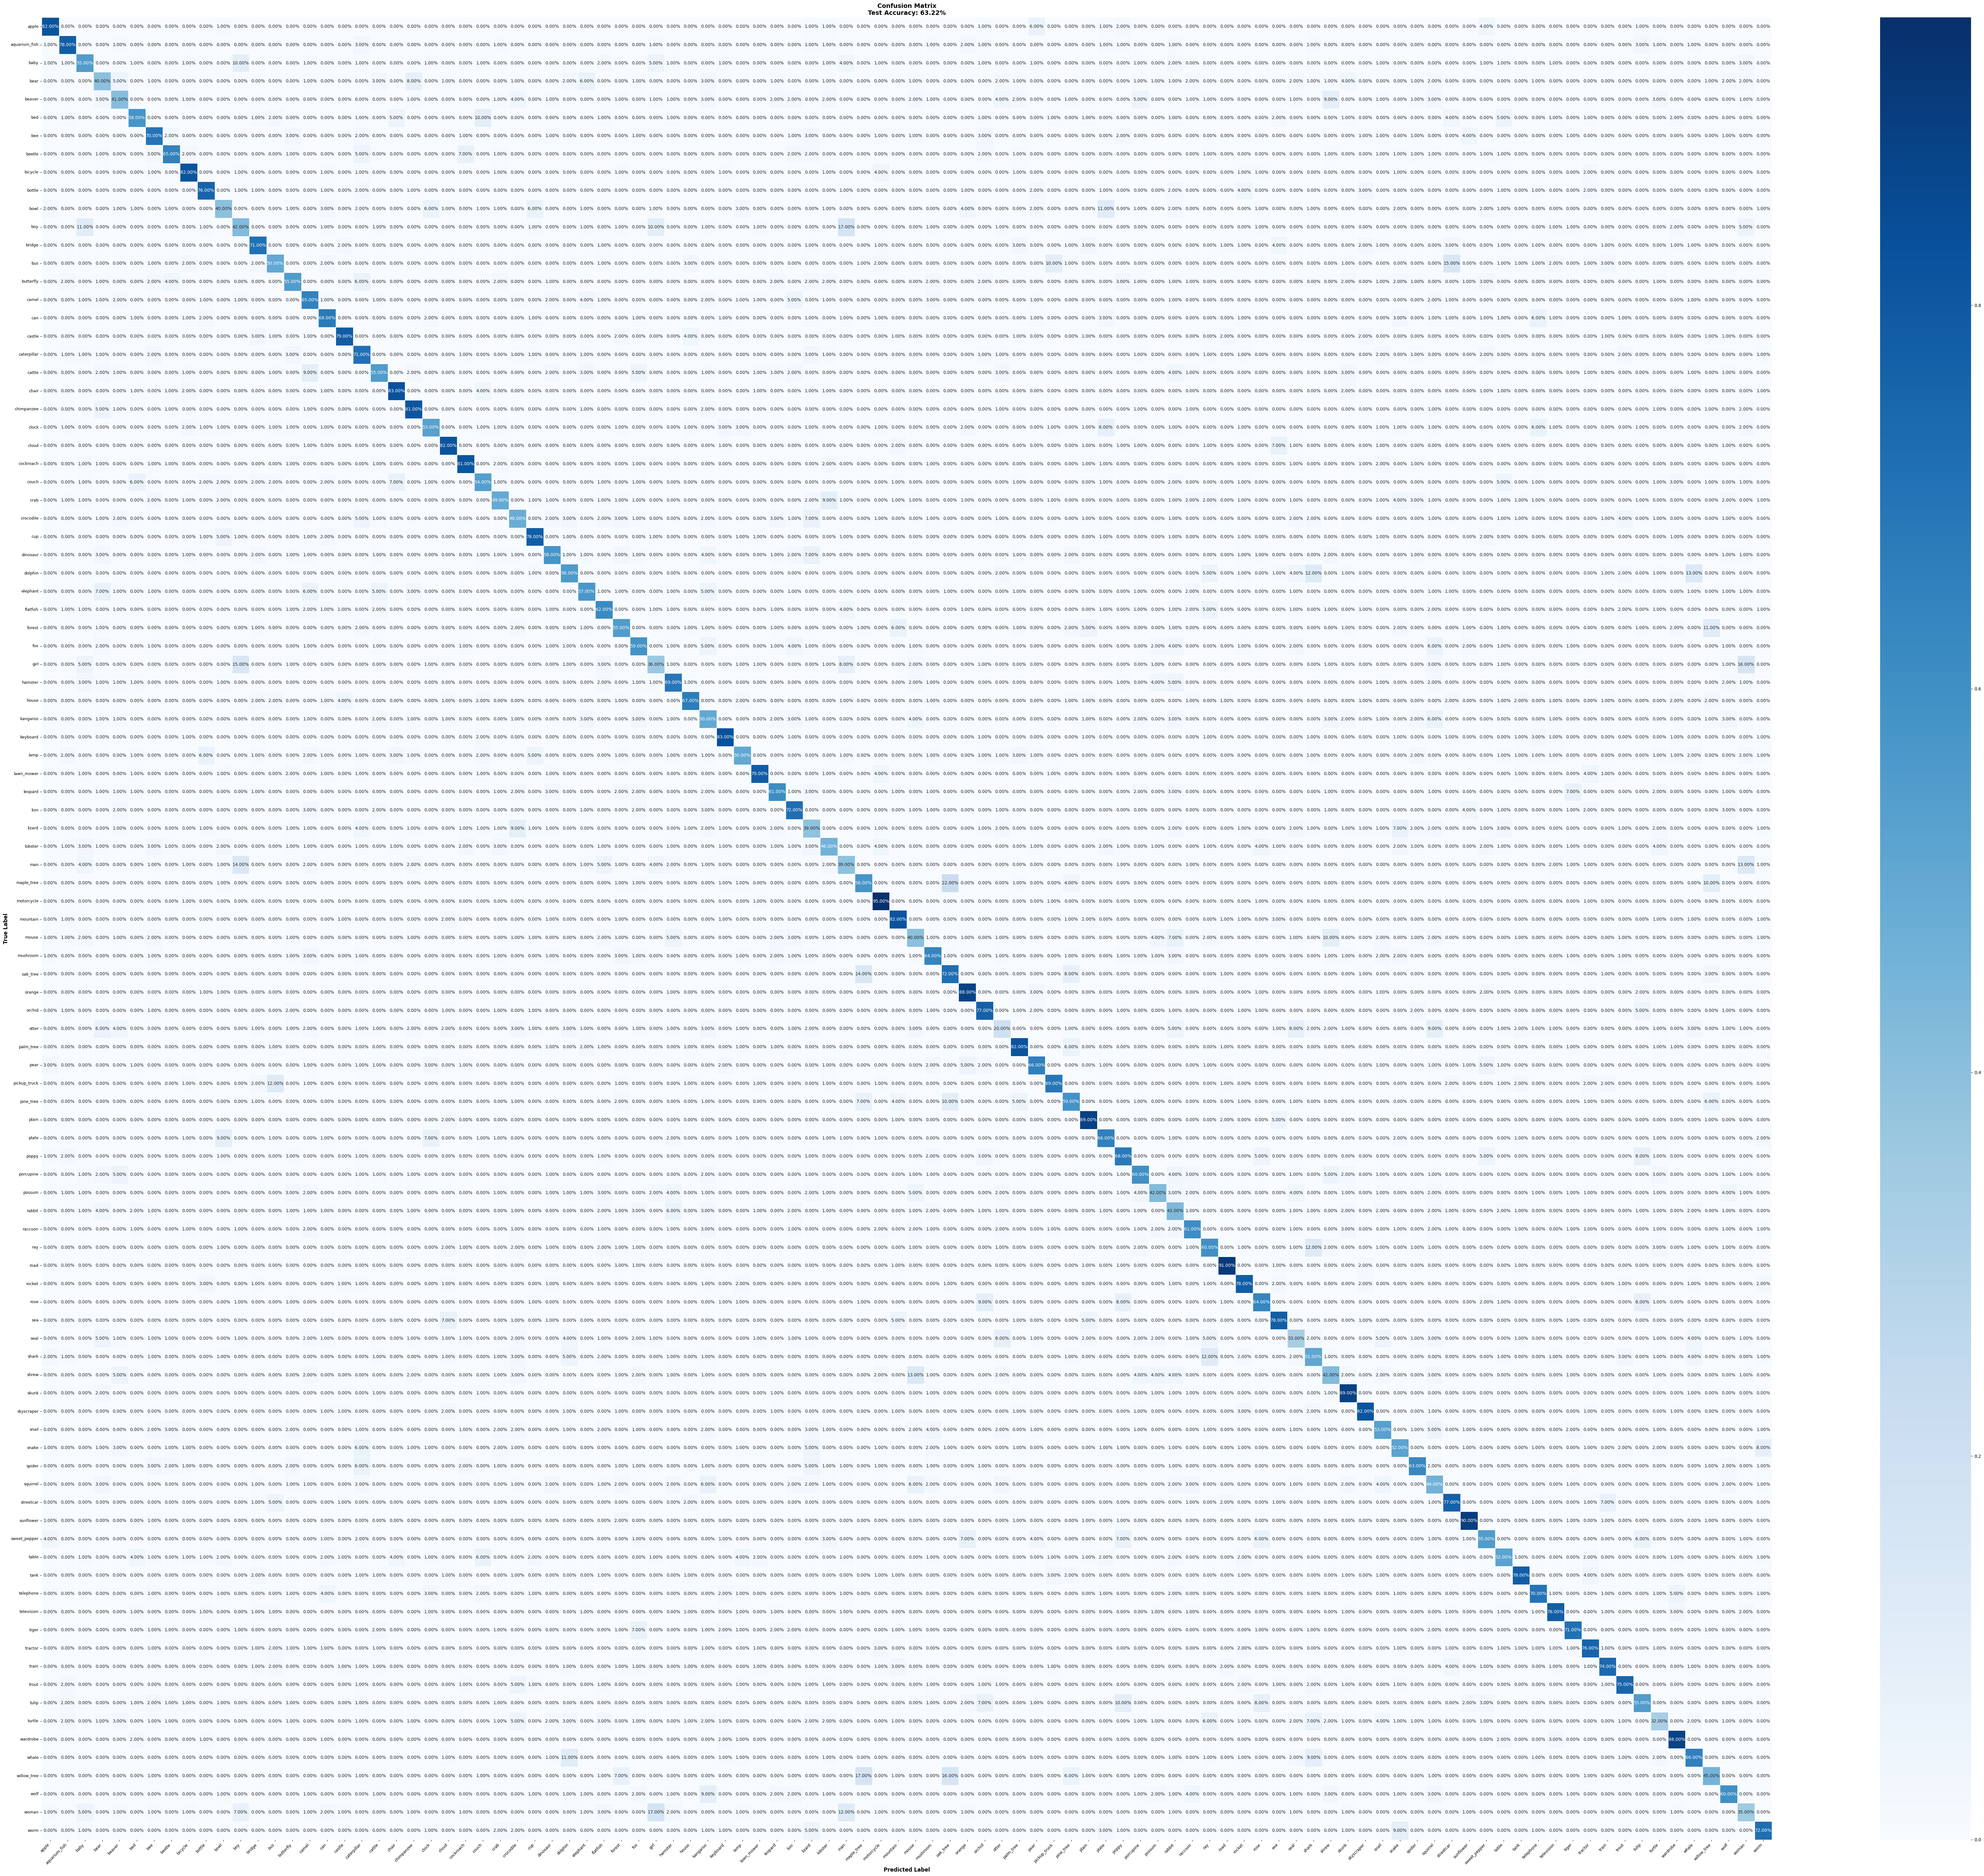


Most Confused Pairs (Errors > 10.00%):
  - True 'bowl' predicted as 'plate': 11.0%
  - True 'boy' predicted as 'baby': 11.0%
  - True 'boy' predicted as 'man': 17.0%
  - True 'bus' predicted as 'streetcar': 15.0%
  - True 'dolphin' predicted as 'shark': 12.0%
  - True 'dolphin' predicted as 'whale': 13.0%
  - True 'forest' predicted as 'willow_tree': 11.0%
  - True 'girl' predicted as 'boy': 15.0%
  - True 'girl' predicted as 'woman': 16.0%
  - True 'man' predicted as 'boy': 14.0%
  - True 'man' predicted as 'woman': 13.0%
  - True 'maple_tree' predicted as 'oak_tree': 22.0%
  - True 'oak_tree' predicted as 'maple_tree': 14.0%
  - True 'pickup_truck' predicted as 'bus': 12.0%
  - True 'ray' predicted as 'shark': 12.0%
  - True 'shark' predicted as 'ray': 12.0%
  - True 'shrew' predicted as 'mouse': 13.0%
  - True 'whale' predicted as 'dolphin': 11.0%
  - True 'willow_tree' predicted as 'maple_tree': 17.0%
  - True 'willow_tree' predicted as 'oak_tree': 16.0%
  - True 'woman' predicted

In [9]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_cifar_train,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)


In [10]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               63.22% 88.17%     79,141       3.9      0.28    3.22   310.5  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 63.22% Top-1 | 79,141 params | 3.22 ± 0.34 ms | 310.5 FPS



Saved → ../figure/solo/train_cifar100_80k.pdf / .png


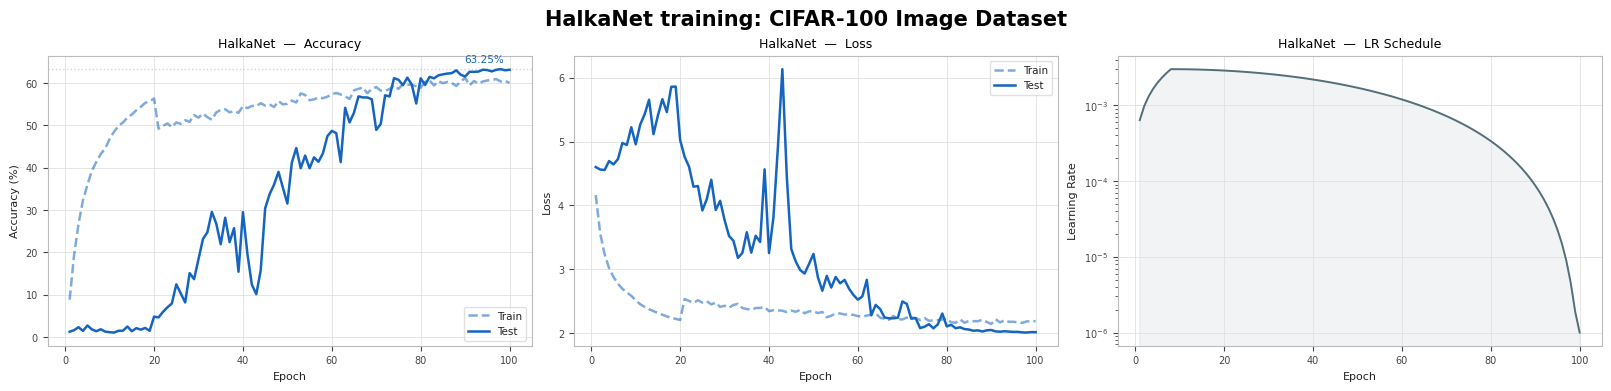

In [11]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/solo/train_cifar100_80k.pdf",
    dataset_name="CIFAR-100 Image Dataset",
    title="HalkaNet training:",
)